In [1]:
#import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#### Load the dataset

In [2]:
df = pd.read_csv('customer_complaint_escalation_textual.csv')

# View first 5 rows
df.head()

,complaint_text,sentiment_score,complaint_channel,product,customer_tier,past_complaints,resolution_attempts,complaint_length,escalated
0,No response from support team,0.59,Social Media,Insurance,Basic,0,3,5,0
1,Delivery was delayed and no proper explanation...,-0.04,Social Media,Insurance,Gold,1,2,9,0
2,The service quality is extremely poor,-0.77,Chat,Mobile App,Silver,2,1,6,1
3,No response from support team,-0.75,Social Media,Insurance,Basic,2,4,5,0
4,The issue has not been resolved despite multip...,0.37,Chat,Internet Service,Platinum,5,4,9,1


#### Basic Dataset Information

In [3]:
# Dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   complaint_text       2500 non-null   object 
 1   sentiment_score      2500 non-null   float64
 2   complaint_channel    2500 non-null   object 
 3   product              2500 non-null   object 
 4   customer_tier        2500 non-null   object 
 5   past_complaints      2500 non-null   int64  
 6   resolution_attempts  2500 non-null   int64  
 7   complaint_length     2500 non-null   int64  
 8   escalated            2500 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 175.9+ KB


In [4]:
# Statistical discription like mean,median,mode etc
df.describe()

,sentiment_score,past_complaints,resolution_attempts,complaint_length,escalated
count,2500.000000,2500.00000,2500.000000,2500.00000,2500.000000
mean,-0.005192,2.57640,3.002400,7.25520,0.410000
std,0.577062,1.69154,1.411663,1.38782,0.491932
min,-1.000000,0.00000,1.000000,5.00000,0.000000
25%,-0.502500,1.00000,2.000000,6.00000,0.000000
50%,0.000000,3.00000,3.000000,8.00000,0.000000
75%,0.490000,4.00000,4.000000,8.00000,1.000000
max,1.000000,5.00000,5.000000,9.00000,1.000000


In [5]:
# No of rows and column
df.shape

(2500, 9)

In [6]:
#checking for null values
df.isna().sum()

complaint_text         0
sentiment_score        0
complaint_channel      0
product                0
customer_tier          0
past_complaints        0
resolution_attempts    0
complaint_length       0
escalated              0
dtype: int64

#### EDA Visuals

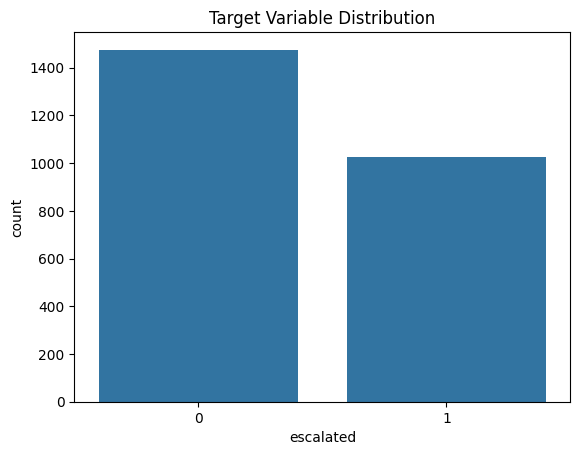

In [7]:
#Target variable analysis
sns.countplot(x='escalated', data=df)
plt.title('Target Variable Distribution')
plt.show()

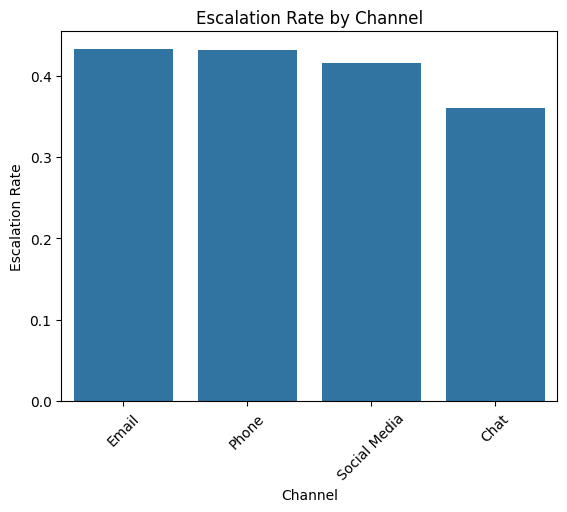

In [8]:
#Escalation rate by channel
channel_escalation = df.groupby('complaint_channel')['escalated'].mean().sort_values(ascending=False)

sns.barplot(x=channel_escalation.index, y=channel_escalation.values)
plt.title('Escalation Rate by Channel')
plt.ylabel('Escalation Rate')
plt.xlabel('Channel')
plt.xticks(rotation=45)
plt.show()

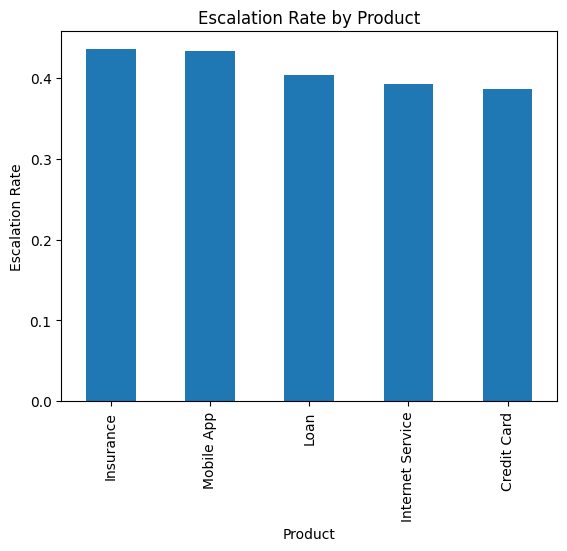

In [9]:
#Escalation rate by product
product_escalation = df.groupby('product')['escalated'].mean().sort_values(ascending=False)

product_escalation.plot(kind='bar')
plt.title('Escalation Rate by Product')
plt.ylabel('Escalation Rate')
plt.xlabel('Product')
plt.show()

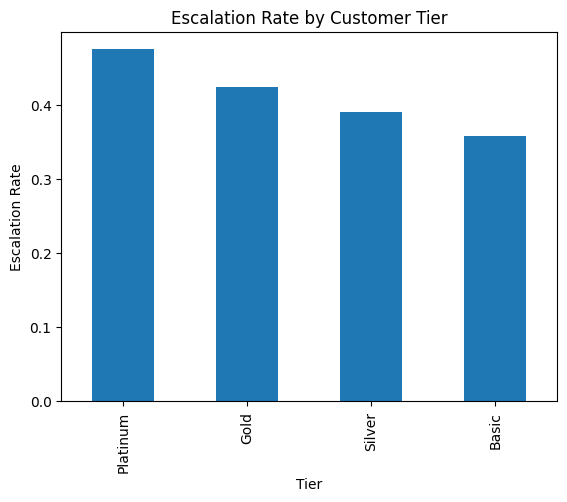

In [10]:
#Escalation rate by customer tier
product_escalation = df.groupby('customer_tier')['escalated'].mean().sort_values(ascending=False)

product_escalation.plot(kind='bar')
plt.title('Escalation Rate by Customer Tier')
plt.ylabel('Escalation Rate')
plt.xlabel('Tier')
plt.show()

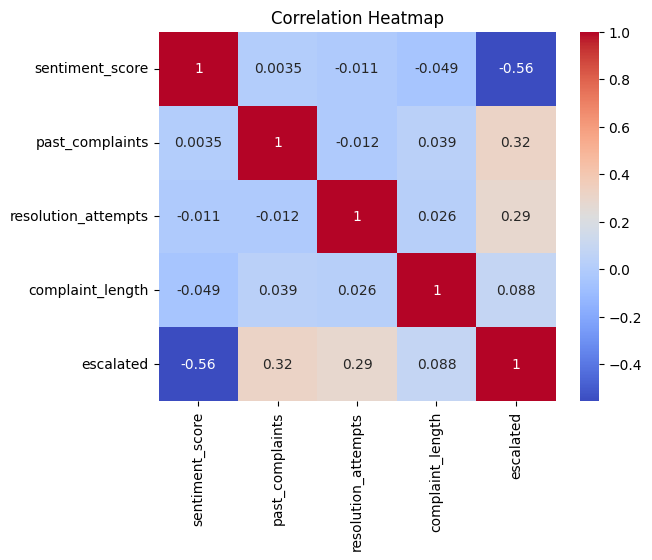

In [11]:
#correlation of numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Encode Categorical Features using Label Encoder

In [12]:
le = LabelEncoder()

for col in ['complaint_channel', 'product', 'customer_tier']:
    df[col] = le.fit_transform(df[col])

df = df.drop(columns=['complaint_text'])

#### Feature & Target Split

In [13]:
X = df.drop('escalated', axis=1)
y = df['escalated']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Models and Hyper Parameter tunig to find best model, Models used- RandomForest, LogistictRegression, DecisionTree, SVM and GradientBoosting¶

In [14]:
models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000),
        {'C': [0.1, 1, 10]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {'max_depth': [5, 10, 15]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [200], 'max_depth': [10, 15]}
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {'n_estimators': [150], 'learning_rate': [0.05, 0.1]}
    ),
    'SVM': (
        SVC(probability=True),
        {'C': [1, 10]}
    )
}

In [16]:
results = []
best_model = None
best_f1 = 0

for name, (model, params) in models.items():
    print(f'\nRunning GridSearchCV for {model}...')
    grid = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.best_estimator_.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_df_sorted = results_df.sort_values(by='F1 Score', ascending=False)
results_df_sorted


Running GridSearchCV for LogisticRegression(max_iter=1000)...

Running GridSearchCV for DecisionTreeClassifier(random_state=42)...

Running GridSearchCV for RandomForestClassifier(random_state=42)...

Running GridSearchCV for GradientBoostingClassifier(random_state=42)...

Running GridSearchCV for SVC(probability=True)...


,Model,Accuracy,Precision,Recall,F1 Score
3,Gradient Boosting,0.832,0.810256,0.770732,0.790000
0,Logistic Regression,0.828,0.793103,0.785366,0.789216
4,SVM,0.830,0.803030,0.775610,0.789082
1,Decision Tree,0.814,0.788660,0.746341,0.766917
2,Random Forest,0.804,0.774359,0.736585,0.755000


BEST MODEL SELECTED: Gradient Boosting

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       295
           1       0.81      0.77      0.79       205

    accuracy                           0.83       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.83      0.83      0.83       500

Final Accuracy: 83.20%


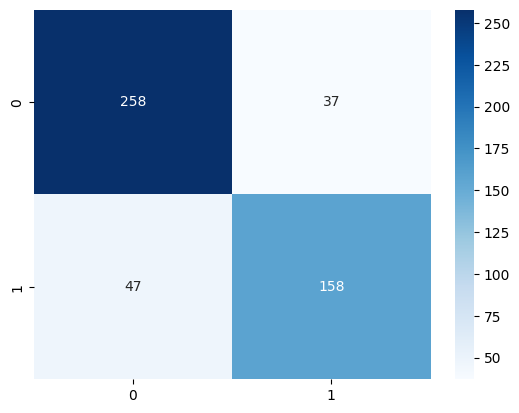

In [17]:
best_model_name = results_df_sorted.iloc[0]['Model']

y_pred_best = best_model.predict(X_test)

print(f'BEST MODEL SELECTED: {best_model_name}\n')
print(classification_report(y_test, y_pred_best))

final_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Final Accuracy: {final_accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
import joblib

joblib.dump(best_model, 'new_best_escalation_model.pkl')
joblib.dump(scaler, 'escalation_scaler.pkl')

print('Model and scaler saved successfully')